# Training our Network

### Introduction

Now that we understand the components of our neural network, it's finally time to train our neural network.  In training our network, we'll need to use both the `feed_forward` function which makes predictions, as well as the back propagation function which will tell us how to update our parameters, the weight matrices and bias vectors of our linear layers.

### Architecting our Network

In this lesson, we'll build a neural network that looks like the following:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \sigma(z_1) \\
z_2 & = a_1W_2 + b_2 \\
\end{aligned}
$$

We have a linear layer, which is passed into the activation layer, here the sigmoid function.  And then the ouputs from the activation layer are fed into our second linear layer, which makes predictions.

We can translate the above into code with the `feed_forward` method.

In [160]:
def forward(x, W1, b1, W2, b2):
    z1 = x.dot(W1) + b1 
    a1 = sigma(z1)
    z2 = a1.dot(W2) + b2
    return (z1, a1, z2)

> Here we return the prediction $z_2$ from the model, as well as $z_1$ and $a_1$ as we will need them later when in computing the gradients.

### Constructing our Weight Matrices

If we look at our data, we see that there are 200 observations, each with two features.

In [121]:
X.shape

(200, 2)

So we need our first weight matrix to have two rows, one for each feature, and we'll decide to have three neurons in that first layer.  

For the second linear layer, because the network is fully connected, the number of inputs to each neuron equals the number of neurons in the previous layer.  Because the second layer is also our output layer, we have two columns -- one for each neuron, to predict each of the potential outputs.

> The divisor helps with the initialization weights - but is beyond the scope of these lessons.

In [122]:
def init_model(n_features, neur_l1, neur_out):
    np.random.seed(0)
    W1 = np.random.randn(n_features, neur_l1) / np.sqrt(n_features)
    b1 = np.zeros((1, neur_l1))
    W2 = np.random.randn(neur_l1, neur_out) / np.sqrt(neur_l1)
    b2 = np.zeros((1, neur_out))
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

Now let's initialize the model. 

In [123]:
# n_features = 2 n_neurons_l1 = 3 n_neurons_ouput = 2 
model = init_model(2, 3, 2)
# model

### Moving to Gradients

We go through the calculation of gradients in a dedicated lesson.  Let's copy and paste the code from there below.

In [124]:
def backwards(L1, a1, W2, Y, Y_hat, X):
    dloss = (Y_hat - Y)
    dX2 = dloss.dot(W2.T) 
    dW2 = (a1.T).dot(dloss)
    db2 = np.sum(dloss, axis=0, keepdims=True)
    d_sigma = sigmoid(L1)*(1 - sigmoid(L1))*dX2
    
    dW1 = np.dot(X.T, d_sigma)
    db1 = np.sum(d_sigma, axis=0)
    
    return (dW1, db1, dW2, db2)

We also need to define the sigmoid function, as our backwards function relies on it.

In [125]:
def sigmoid(x): return 1/(1 + np.exp(-x))

One more note about the above functin, note that it returns a tuple of the gradients of all of our parameters -- $W1$, $b1$, $W2$, $b2$.  It does not *update* the parameters itself.  It just calculates the derivatives.

The updating occurs in the `step` function.  The step function takes in the parameters of the current version of the neural network, as well as the amount to update them by, and updates the parameters accordingly.  We also pass through our learning rate, eta, $\eta$.

In [126]:
eta = .001
def step(W1, b1, W2, b2, dW2, db2, dW1, db1, eta):
    W1 += -eta * dW1
    b1 += -eta * db1
    W2 += -eta * dW2
    b2 += -eta * db2
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

### Calculating the Loss

In [162]:
Y = np.stack([scalar_to_index(y_val) for y_val in y])

def scalar_to_index(val, num_options = 2):
    y_ar = [0]*num_options
    y_ar[val] = 1
    return y_ar

def calculate_loss(y, Y_hat):
    Y = np.stack([scalar_to_index(y_val) for y_val in y])
    total_error = ((Y - Y_hat)**2).sum()
    return total_error

### Train Model

In [166]:
def train_model(nn_hdim, num_passes=20000, print_loss=False):
    model = init_model(2, 3, 2)
    for i in range(0, num_passes):          
        W1, b1, W2, b2 = tuple(model.values())
        (z1, a1, y_hats) = forward(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backwards(z1, a1, W2, Y, y_hats, X)
        model = step(W1, b1, W2, b2, dW2, db2, dW1, db1, eta)
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(y, y_hats)))
    return model

### Executing the model

In [167]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from sklearn.datasets import make_moons

np.random.seed(0)
X, y = make_moons(200, noise=0.20)

In [1]:
# model = train_model(3, num_passes=60000, print_loss=True)

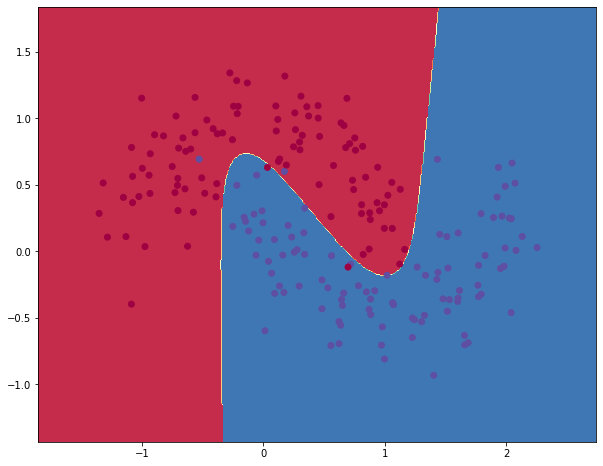

In [172]:
def plot_decision_boundary(pred_func, X):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = sigmoid(z1)
    z2 = a1.dot(W2) + b2
    return np.argmax(z2, axis=1)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), X)
# plt.title("Decision Boundary for hidden layer size 3")

### Resources

[Code based on wildml's blog post](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)

[gradient of bias](https://datascience.stackexchange.com/questions/20139/gradients-for-bias-terms-in-backpropagation)

[derivative of softmax](https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function)

[softmax](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)

[cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)